# 14.3 US Baby Names 1880–2010（1880年至2010年美国婴儿姓名）

这个数据是从1880年到2010年婴儿名字频率数据。

数据集可以用来做很多事，例如：

- 计算指定名字的年度比例
- 计算某个名字的相对排名
- 计算各年度最流行的名字，以及增长或减少最快的名字
- 分析名字趋势：元音、辅音、长度、总体多样性、拼写变化、首尾字母等
- 分析外源性趋势：圣经中的名字、名人、人口结构变化等

下载National data之后，会得到names.zip文件，解压后，可以看到一系列类似于yob1880.txt这样名字的文件，说明这些文件是按年份记录的。这里使用Unix head命令查看一下文件的前10行：

由于这是一个非常标准的以逗号隔开的格式（即CSV文件），所以可以用pandas.read_csv将其加载到DataFrame中：

In [7]:
import pandas as pd

In [9]:

pd.options.display.max_rows = 10

In [10]:
names1880 = pd.read_csv('../datasets/babynames/yob1880.txt', names=['names', 'sex', 'births'])

In [11]:
names1880

,names,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


这些文件中仅含有当年出现超过5次以上的名字。为了简单化，我们可以用births列的sex分组小计，表示该年度的births总计：

In [12]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

由于该数据集按年度被分割成了多个文件，所以第一件事情就是要将所有数据都组装到一个DataFrame里面，并加上一个year字段。使用pandas.concat可以做到：

In [13]:
# 2010是最后一个有效统计年度
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = '../datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)
    
# 将所有数据整合到单个DataFrame中
names = pd.concat(pieces, ignore_index=True)

In [14]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


有了这些数据后，我们就可以利用groupby或pivot_table在year和sex界别上对其进行聚合了：

In [15]:
total_births = names.pivot_table('births', index='year',
                                columns='sex', aggfunc=sum)

In [16]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


In [17]:
import seaborn as sns
%matplotlib inline

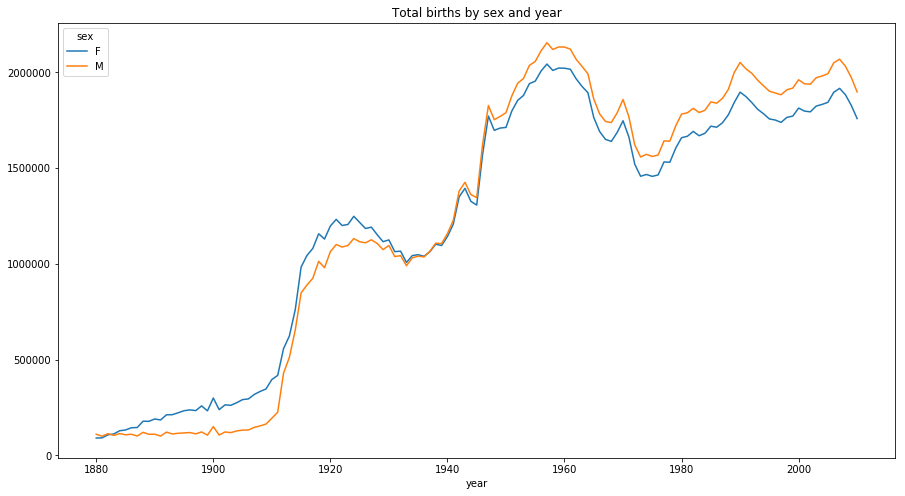

In [18]:
total_births.plot(title='Total births by sex and year', figsize=(15, 8))

插入一个prop列，用于存放指定名字的婴儿数相对于总出生数的比列。prop值为0.02表示每100名婴儿中有2名取了当前这个名字。因此，我们先按year和sex分组，然后再将新列加到各个分组上：

In [19]:
def add_prop(group): 
    group['prop'] = group.births / group.births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop)

In [20]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


In [22]:
names.groupby(['year', 'sex']).prop.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

这样就算完活了。为了便于实现进一步的分析，我们需要取出该数据的一个子集：每对sex/year组合的前1000个名字。这又是一个分组操作：

In [23]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

# Drop the group index, not needed
top1000.reset_index(inplace=True, drop=True)

In [24]:
pieces =[]
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
    
top1000 = pd.concat(pieces, ignore_index=True)

In [25]:
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


接下来针对这个top1000数据集，我们就可以开始数据分析工作了

# 1 Analyzing Naming Trends（分析命名趋势）

有了完整的数据集和刚才生成的top1000数据集，我们就可以开始分析各种命名趋势了。首先将前1000个名字分为男女两个部分：


In [26]:
boys = top1000[top1000.sex=='M']
girls = top1000[top1000.sex=='F']

这是两个简单的时间序列，只需要稍作整理即可绘制出相应的图标，比如每年叫做John和Mary的婴儿数。我们先生成一张按year和name统计的总出生数透视表：

In [27]:
total_births = top1000.pivot_table('births', index='year', 
                                   columns='name', aggfunc=sum)

total_births

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,...,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,...,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,...,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,...,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,...,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,...,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,NaN,3737.0,NaN,8279.0,NaN,NaN,297.0,NaN,404.0,440.0,...,NaN,5145.0,2839.0,530.0,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,3941.0,NaN,8914.0,NaN,NaN,313.0,NaN,349.0,468.0,...,NaN,4925.0,3028.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN
2008,955.0,4028.0,219.0,8511.0,NaN,NaN,317.0,NaN,344.0,400.0,...,NaN,4764.0,3438.0,492.0,NaN,NaN,NaN,NaN,NaN,NaN


接下来使用DataFrame中的plot方法：

In [28]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


In [29]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017BF1978>,
      dtype=object)

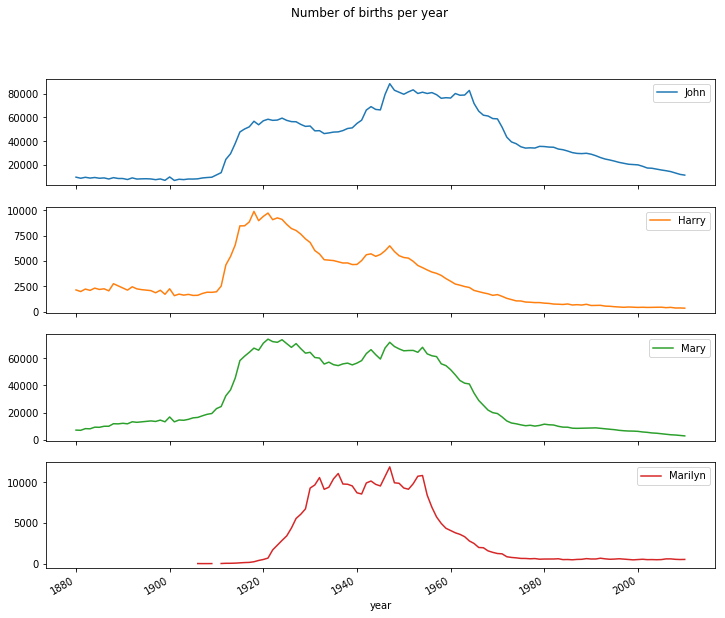

In [30]:
subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

## 评价命名多样性的增长

上图反应的降低情况可能意味着父母愿意给小孩起常见的名字越来越少。这个假设可以从数据中得到验证。一个办法是计算最流行的1000个名字所占的比例，我们按year和sex进行聚合并绘图：

In [31]:
import numpy as np

In [32]:
table = top1000.pivot_table('prop', index='year',
                           columns='sex', aggfunc=sum)

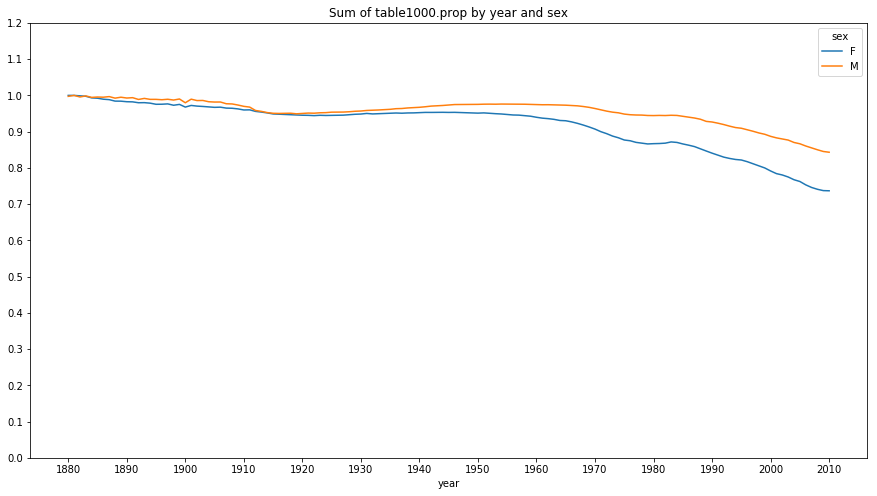

In [33]:
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10),
           figsize=(15, 8))

从图中可以看出，名字的多样性确实出现了增长（前1000项的比例降低）。另一个办法是计算占总出生人数前50%的不同名字的数量，这个数字不太好计算。我们只考虑2010年男孩的名字：

In [34]:
df = boys[boys.year == 2010]

In [35]:
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


对prop降序排列后，我们想知道前面多少个名字的人数加起来才够50%。虽然编写一个for循环也能达到目的，但NumPy有一种更聪明的矢量方式。先计算prop的累计和cumsum，，然后再通过searchsorted方法找出0.5应该被插入在哪个位置才能保证不破坏顺序：

In [36]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [37]:
prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [38]:
prop_cumsum.searchsorted(0.5)

array([116], dtype=int64)

由于数组索引是从0开始的，因此我们要给这个结果加1，即最终结果为117。拿1900年的数据来做个比较，这个数字要小得多：

In [39]:
df = boys[boys.year == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900[-10:]

41853    0.979223
41852    0.979277
41851    0.979330
41850    0.979383
41849    0.979436
41848    0.979489
41847    0.979542
41846    0.979595
41845    0.979648
41876    0.979702
Name: prop, dtype: float64

In [40]:
in1900.searchsorted(0.5) + 1

array([25], dtype=int64)

现在就可以对所有year/sex组合执行这个计算了。按这两个字段进行groupby处理，然后用一个函数计算各分组的这个值：

In [41]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

现在，这个diversity有两个时间序列（每个性别各一个，按年度索引）。通过IPython，可以看到其内容，还可以绘制图标

In [42]:
diversity.head()

sex,F,M
year,,
1880,[38],[14]
1881,[38],[14]
1882,[38],[15]
1883,[39],[15]
1884,[39],[16]


可以看到上面表格中的值为list，如果不加diversity=diversity.astype(float)的话，会报错显示，“no numeric data to plot” error。通过加上这句来更改数据类型，就能正常绘图了：

In [43]:
diversity = diversity.astype('float')
diversity

sex,F,M
year,,
1880,38.0,14.0
1881,38.0,14.0
1882,38.0,15.0
1883,39.0,15.0
1884,39.0,16.0
...,...,...
2006,209.0,99.0
2007,223.0,103.0
2008,234.0,109.0


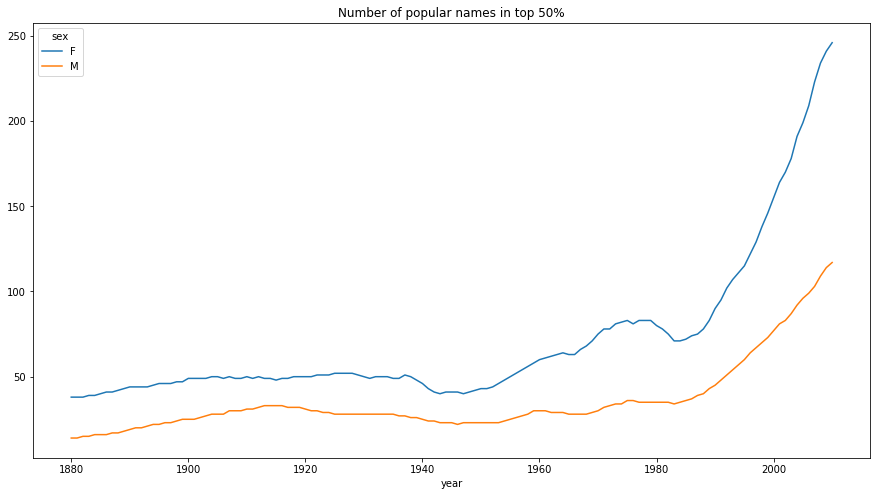

In [44]:
diversity.plot(title='Number of popular names in top 50%', figsize=(15, 8))

从图中可以看出，女孩名字的多样性总是比男孩高，而且还变得越来越高。我们可以自己分析一下具体是什么在驱动这个多样性（比如拼写形式的变化）。

## “最后一个字母”的变革

一位研究人员指出：近百年来，男孩名字在最后一个字母上的分布发生了显著的变化。为了了解具体的情况，我们首先将全部出生数据在年度、性别以及末字母上进行了聚合：

In [45]:
# 从name列中取出最后一个字母
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters,
                          columns=['sex', 'year'], aggfunc=sum)

In [46]:
print(type(last_letters))
print(last_letters[:5])

<class 'pandas.core.series.Series'>
0    y
1    a
2    a
3    h
4    e
Name: last_letter, dtype: object


然后，我们选出具有一个代表性的三年，并输出前几行：

In [47]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

接下来我们需要安总出生数对该表进行规范化处理，一遍计算出个性别各末字母站总出生人数的比例：

In [48]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [49]:
letter_prop = subtable / subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
...               ...       ...       ...       ...       ...       ...
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

[26 rows x 6 columns]

有了这个字母比例数据后，就可以生成一张各年度各性别的条形图了：

In [50]:
import matplotlib.pyplot as plt

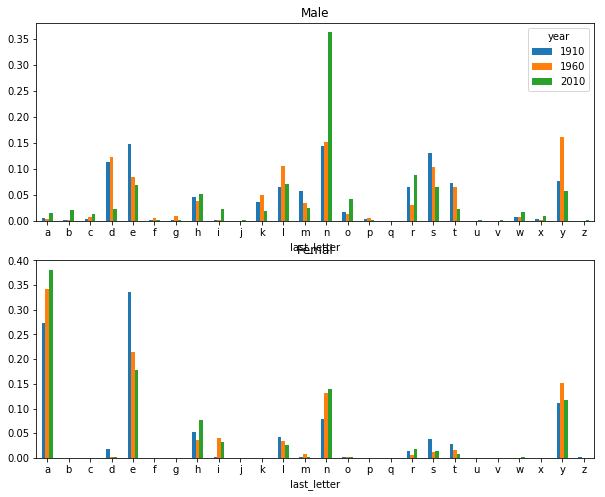

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Femal', legend=False)

从上图可以看出来，从20世纪60年代开始，以字母'n'结尾的男孩名字出现了显著的增长。回到之前创建的那个完整表，按年度和性别对其进行规范化处理，并在男孩名字中选取几个字母，最后进行转置以便将各个列做成一个时间序列：

In [52]:
letter_prop = table / table.sum()
letter_prop.head()

sex                 F                                                    \
year             1880      1881      1882      1883      1884      1885   
last_letter                                                               
a            0.345587  0.343440  0.338764  0.341251  0.338550  0.341270   
b                 NaN       NaN       NaN       NaN       NaN       NaN   
c                 NaN       NaN  0.000046  0.000045       NaN       NaN   
d            0.006693  0.006601  0.006806  0.007211  0.007100  0.006478   
e            0.366819  0.370616  0.374582  0.373159  0.372722  0.372896   

sex                                                    ...            M  \
year             1886      1887      1888      1889    ...         2001   
last_letter                                            ...                
a            0.339703  0.335258  0.332764  0.328706    ...     0.020162   
b                 NaN       NaN       NaN       NaN    ...     0.026256   
c                 NaN       NaN       NaN       NaN    ...     0.013972   
d            0.006967  0.007035  0.007266  0.007703    ...     0.031352   
e            0.372802  0.372324  0.373675  0.373736    ...     0.074927   

sex                                                                      \
year             2002      2003      2004      2005      2006      2007   
last_letter                                                               
a            0.020019  0.019177  0.019505  0.018481  0.017635  0.016747   
b            0.025418  0.024368  0.023171  0.021645  0.020778  0.020357   
c            0.014048  0.014042  0.013514  0.013083  0.012991  0.012983   
d            0.028794  0.027069  0.026118  0.025420  0.025075  0.024451   
e            0.074603  0.073396  0.071710  0.070799  0.069748  0.069445   

sex                                        
year             2008      2009      2010  
last_letter                                
a            0.016189  0.015927  0.014980  
b            0.019655  0.019693  0.020470  
c            0.012458  0.012186  0.012181  
d            0.023574  0.023398  0.023387  
e            0.069362  0.068663  0.067959  

[5 rows x 262 columns]

In [53]:
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


有了这个时间序列的DataFrame后，就可以通过其plot方法绘制出一张趋势图：

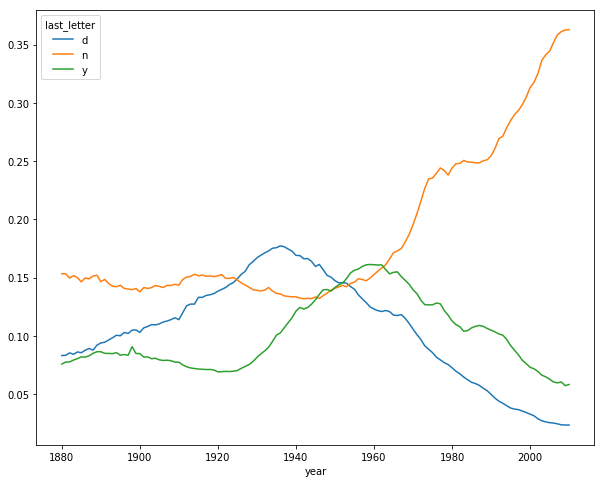

In [54]:
dny_ts.plot(figsize=(10, 8))

## 变成女孩名字的男孩名字（以及相反的情况）

另一个有趣的趋势是，早年流行于男孩的名字近年来“变性了”，列入Lesley或Leslie。回到top1000数据集，找出其中以"lesl"开头的一组名字：

In [55]:
all_names = pd.Series(top1000.name.unique())
lesley_like = all_names[all_names.str.lower().str.contains('lesl')]
lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

然后利用这个结果过滤其他的名字，并按名字分组计算出生数以查看相对频率：

In [56]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

接下来，我们按性别和年度进行聚合，并按年度进行规范化处理：

In [57]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')

table = table.div(table.sum(1), axis=0)

In [58]:
table

sex,F,M
year,,
1880,0.091954,0.908046
1881,0.106796,0.893204
1882,0.065693,0.934307
1883,0.053030,0.946970
1884,0.107143,0.892857
...,...,...
2006,1.000000,NaN
2007,1.000000,NaN
2008,1.000000,NaN


现在，我们可以轻松绘制一张分性别的年度曲线图了：

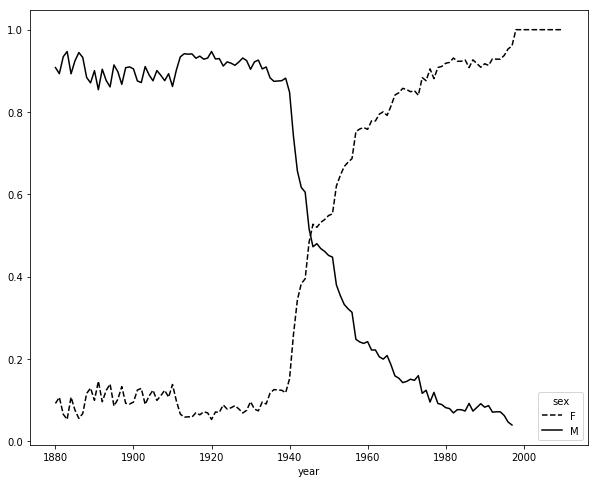

In [59]:
table.plot(style={'M': 'k-', 'F': 'k--'}, figsize=(10, 8))